Exercise: *Go through TensorFlow’s [Style Transfer tutorial](https://www.tensorflow.org/tutorials/generative/style_transfer). This is a fun way to generate art using deep learning.*

- This tutorial is derived from the TensorFlow's notebook, linked above.
- The notebook is licensed under the Apache License, Version 2.0, so be mindful about it.

# Neural style transfer

## Set up

### Import and configure models

In [39]:
import os
import tensorflow as tf

# Load compressed models from tensorflow_hub
os.environ["TFHUB_MODEL_LOAD_FORMAT"] = "COMPRESSED"

In [40]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams["figure.figsize"] = (12, 12)
mpl.rcParams["axes.grid"] = False

import numpy as np
import PIL.Image
import time

In [41]:
def tensor_to_image(tensor):
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

Now we download images and choose a style image and a content image.

In [42]:
content_path = tf.keras.utils.get_file(
    "YellowLabradorLooking_new.jpg",
    "https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg",
)
style_path = tf.keras.utils.get_file(
    "kandinsky5.jpg",
    "https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg",
)

## Visualize the input

We define a function to load an image and limits its maximum dimension to 512 pixels.

In [43]:
def load_image(image_path):
    max_dim = 512
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

Create a simple function to display an image:

In [44]:
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)

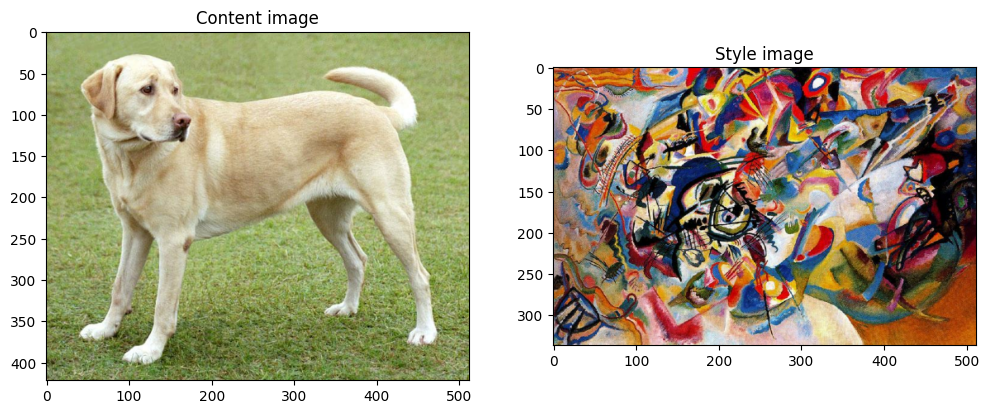

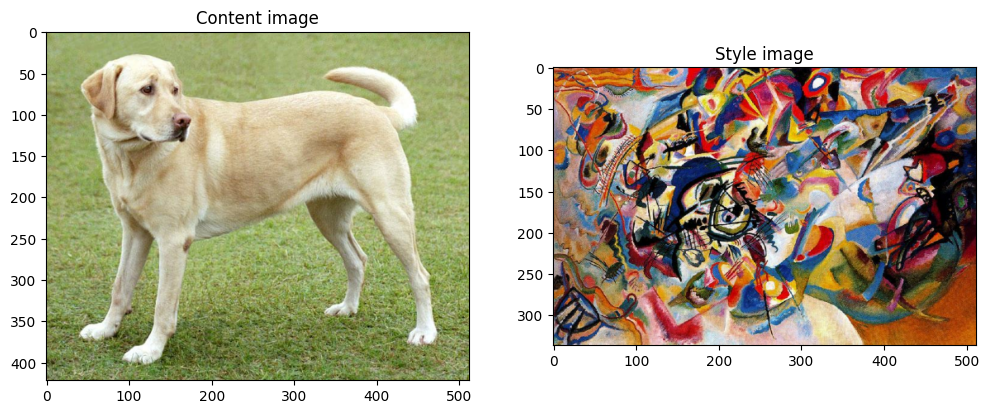

In [45]:
content_image = load_image(content_path)
style_image = load_image(style_path)

plt.subplot(121)
imshow(content_image, "Content image")

plt.subplot(122)
imshow(style_image, "Style image")

## Fast Style Transfer using TF-Hub

- This tutorial demonstrates the original style-transfer algorithm, which optimizes the image content to a particular style.
- Before getting into the details, let's see how the [TensorFlow Hub model](https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2) does this:

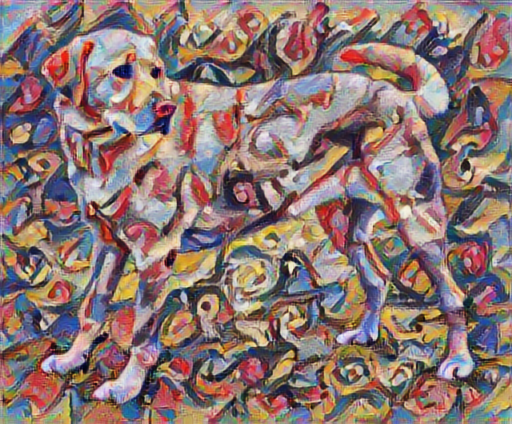

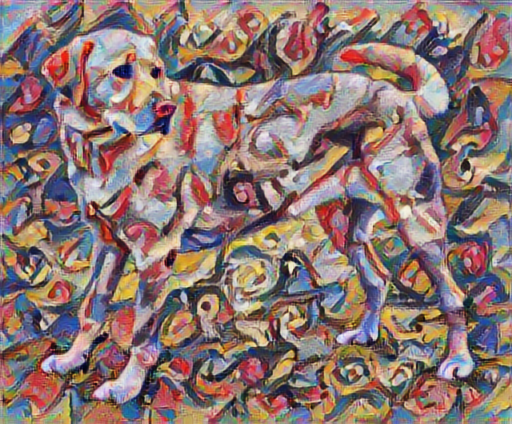

In [46]:
import tensorflow_hub as hub

hub_model = hub.load(
    "https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2"
)
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

## Define content and style representations

Load a [VGG19](https://keras.io/api/applications/vgg/#vgg19-function) and test it on our image to ensure    it's used correctly.

In [47]:
x = tf.keras.applications.vgg19.preprocess_input(content_image * 255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights="imagenet")
prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 1000])

TensorShape([1, 1000])

In [48]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(
    prediction_probabilities.numpy()
)[0]
[(class_name, proba) for (number, class_name, proba) in predicted_top_5]

[('Labrador_retriever', 0.49317107),
 ('golden_retriever', 0.23665293),
 ('kuvasz', 0.03635751),
 ('Chesapeake_Bay_retriever', 0.024182767),
 ('Greater_Swiss_Mountain_dog', 0.018646102)]

[('Labrador_retriever', 0.49317107),
 ('golden_retriever', 0.23665293),
 ('kuvasz', 0.03635751),
 ('Chesapeake_Bay_retriever', 0.024182767),
 ('Greater_Swiss_Mountain_dog', 0.018646102)]

Now we load the `VGG19` model without the top layers, and list the layer names:

In [49]:
vgg = tf.keras.applications.VGG19(include_top=False, weights="imagenet")

print()
for layer in vgg.layers:
    print(layer.name)


input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool

input_6
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


Choose intermediate layers from the network to represent the style and the content of the image:

In [50]:
content_layers = ["block5_conv2"]
style_layers = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

## Build the model

- The networks in `tf.keras.applications` are designed so you can easily extract the intermediate layer values by using Keras Functional API.
- To define a model using the Functional API, specify the inputs and outputs.
- The following function builds a VGG19 model that returns a list of intermediate layer outputs:

In [51]:
def vgg_layers(layer_names):
    """Creates a VGG model that returns a list of intermediate output values."""
    vgg = tf.keras.applications.VGG19(include_top=False, weights="imagenet")
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

And to create the model:

In [52]:
def statistics(name, output):
    # print(name)
    # print("  shape:  ", output.numpy().shape)
    # print("  min:  ", output.numpy().min())
    # print("  max:  ", output.numpy().max())
    # print("  mean:  ", output.numpy().mean())
    # print()
    pass

In [53]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image * 255)

# Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
    statistics(name, output)

## Calculate style

In [54]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum("bijc,bijd->bcd", input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
    return result / num_locations

## Extract style and content

Now we build a model that returns the style and the content tensors:

In [55]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        "Expects float input in [0,1]"
        inputs = inputs * 255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (
            outputs[: self.num_style_layers],
            outputs[self.num_style_layers :],
        )

        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]

        style_dict = {
            style_name: value
            for style_name, value in zip(self.style_layers, style_outputs)
        }

        content_dict = {
            content_name: value
            for content_name, value in zip(self.content_layers, content_outputs)
        }

        return {"content": content_dict, "style": style_dict}

When called on an image, this model returns the Gram matrix (style) of the `style_layer` and content of the `content_layers`.

In [56]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print("Style:")
for name, output in sorted(results["style"].items()):
    statistics(name, output)

print("Content:")
for name, output in sorted(results["content"].items()):
    statistics(name, output)

Style:
Content:
Style:
Content:


## Run gradient descent

In [57]:
style_targets = extractor(style_image)["style"]
content_targets = extractor(content_image)["content"]

Define a `tf.Variable` to contain the image to optimize. To make this quick, we will initialize it with the content image (the `tf.Variable` must be the same shape as the content image).

In [58]:
image = tf.Variable(content_image)

This is a float image, so we define a function to clip the pixel values between 0 and 1.

In [59]:
def clip_0_1(value):
    return tf.clip_by_value(value, clip_value_min=0.0, clip_value_max=1.0)

Create an optimizer. The paper recommends LBFGS, but Adam works okay, too.

In [60]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

To optimize this, use a weighted combination of the two losses to get the total loss.

In [61]:
style_weight = 1e-2
content_weight = 1e4

In [62]:
def style_content_loss(outputs):
    style_outputs = outputs["style"]
    content_outputs = outputs["content"]

    style_loss = tf.add_n(
        [
            tf.reduce_mean((style_outputs[name] - style_targets[name]) ** 2)
            for name in style_outputs.keys()
        ]
    )
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n(
        [
            tf.reduce_mean((content_outputs[name] - content_targets[name]) ** 2)
            for name in content_outputs.keys()
        ]
    )
    content_loss *= content_weight / num_content_layers

    loss = style_loss + content_loss
    return loss

Use `tf.GradientTape` to update the image.

In [63]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)

    gradient = tape.gradient(loss, image)
    optimizer.apply_gradients([(gradient, image)])
    image.assign(clip_0_1(image))

We run a few steps to test if it works

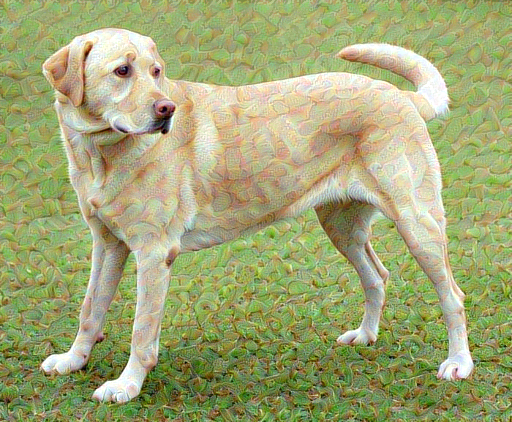

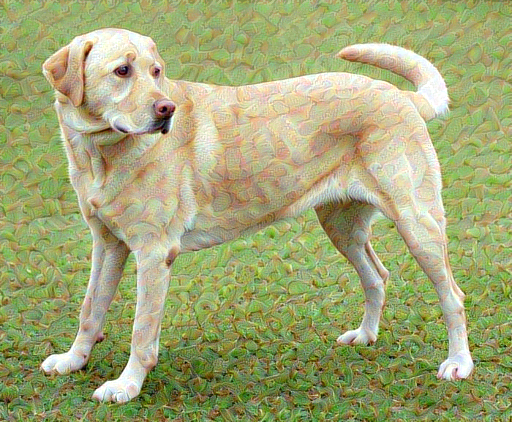

In [64]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

Okay, it works, so we perform a longer optimization.

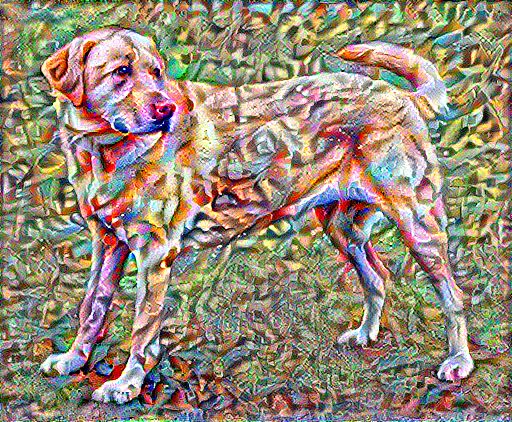

Train_step: <tensorflow.python.eager.polymorphic_function.polymorphic_function.Function object at 0x7ccb281627a0>
....................................................................................................

In [27]:
import time

start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end="", flush=True)
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train_step: {}".format(step))

end = time.time()
print("Total time: {:.1f} s".format(end - start))

## Total Variation Loss

In [28]:
def high_pass_x_y(image):
    x_var = image[:, :, 1:, :] - image[:, :, :-1]
    y_var = image[:, 1:, :, :] - image[:, :-1, :, :]
    return x_var, y_var

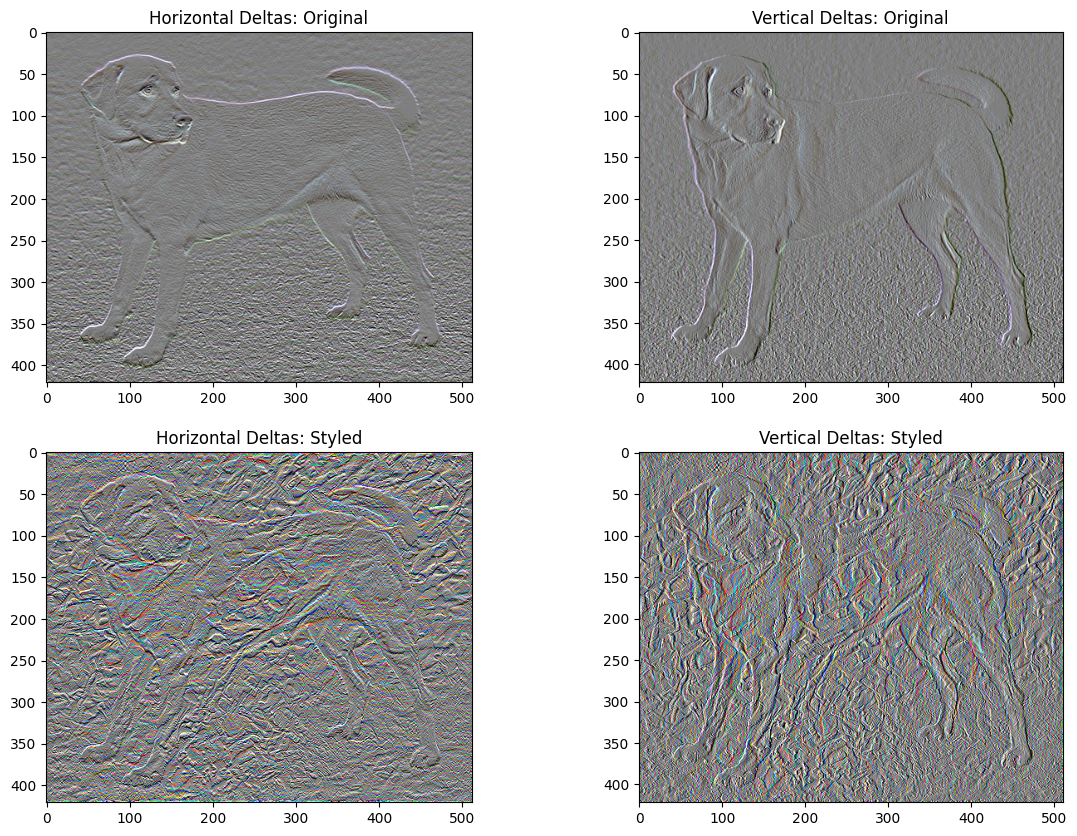

In [29]:
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14, 10))
plt.subplot(221)
imshow(clip_0_1(2 * y_deltas + 0.5), "Horizontal Deltas: Original")

plt.subplot(222)
imshow(clip_0_1(2 * x_deltas + 0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(223)
imshow(clip_0_1(2 * y_deltas + 0.5), "Horizontal Deltas: Styled")

plt.subplot(224)
imshow(clip_0_1(2 * x_deltas + 0.5), "Vertical Deltas: Styled")

plt.show()

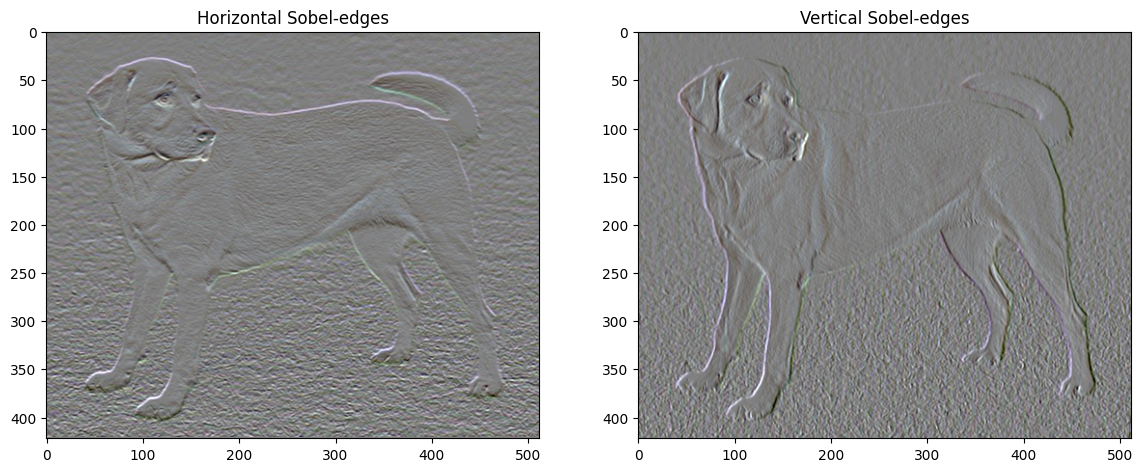

In [30]:
plt.figure(figsize=(14, 10))

sobel = tf.image.sobel_edges(content_image)
plt.subplot(121)
imshow(clip_0_1(sobel[..., 0] / 4 + 0.5), "Horizontal Sobel-edges")
plt.subplot(122)
imshow(clip_0_1(sobel[..., 1] / 4 + 0.5), "Vertical Sobel-edges")

The regularization loss associated with this is the sum of the squares of the values.

In [31]:
def total_variation_loss(image):
    x_deltas, y_deltas = high_pass_x_y(image)
    return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [32]:
total_variation_loss(image).numpy()

149192.08

This demonstrates what it does. But there's no need to implement it yourself, TensorFlow includes a standard implementation:

In [33]:
tf.image.total_variation(image).numpy()

array([149192.08], dtype=float32)

## Re-run the optimization

Choose a weight for `total_variation_weight`.

In [34]:
total_variation_weight = 30

Now include it in the `train_step` function.

In [35]:
@tf.function
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
        loss += total_variation_weight * tf.image.total_variation(image)

    gradient = tape.gradient(loss, image)
    optimizer.apply_gradients([(gradient, image)])
    image.assign(clip_0_1(image))

Reinitialize the image variable and the optimizer.

In [36]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
image = tf.Variable(content_image)

Run the optimization

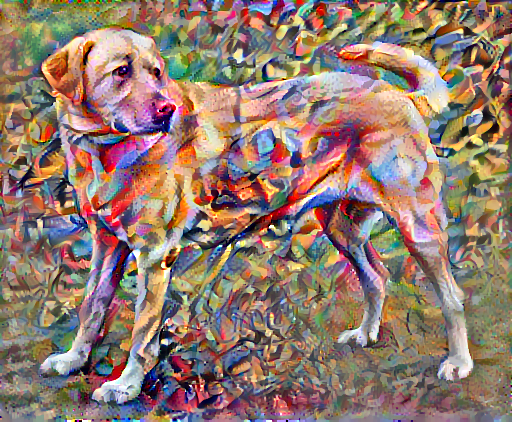

Train_step: <tensorflow.python.eager.polymorphic_function.polymorphic_function.Function object at 0x7ccb326b9b70>
Total time: 81.89166736602783


In [37]:
import time

start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end="", flush=True)
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train_step: {}".format(step))

end = time.time()
print("Total time: {:.1f} s".format(end - start))

In [38]:
file_name = 'stylized-image.png'
tensor_to_image(image).save(file_name)

try:
    from google.colab import files
except ImportError:
    pass
else:
    files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>